## EDA for Machine Learning

In this notebook we are trying to find features which will help us make better predictions.

In [2]:
import spacy
import sys
sys.path.append('../')
from importlib import reload
import libs.ml as ml
import libs.utils as utils
import libs.stats as stats
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [3]:
df2_en = utils.load_dataframe(language='en',version=2)
nlp_en = spacy.load('en')

In [4]:
import nltk
tmp_model_answers = df2_en['Model Answer'].as_matrix()

def negative_seeds(model_answers, size=500):
    seed_data = nltk.corpus.gutenberg.sents('austen-sense.txt')
    seed_len = len(seed_data)
    indices = np.random.choice(seed_len, size=size, replace=False)
    results = []
    for index in indices:
        sent = seed_data[index]
        ma = np.random.choice(model_answers)
        sa = ' '.join(sent)
        results.append([ma,sa])
        
    return np.array(results)
    
df2_en_x_ext = negative_seeds(tmp_model_answers, size=800)
df2_en_y_ext = np.zeros(800)

In [5]:
## Split up the data
from sklearn.model_selection import train_test_split

df2_en_x = df2_en[['Model Answer', 'Student Answer']].as_matrix()
df2_en_y = df2_en['Score'].as_matrix()
df2_en_x2 = np.concatenate((df2_en_x, df2_en_x_ext), axis=0)
df2_en_y2 = np.append(df2_en_y, df2_en_y_ext)

train_x, test_x, train_y, test_y = train_test_split(df2_en_x2, df2_en_y2, test_size=0.2, random_state=42)
print(len(train_x))
print(len(test_x))

2593
649


In [6]:
import libs.vsm as vsm
gensim_model = vsm.load_gensim_model(model_name='glove-wiki-gigaword-300')

In [9]:
from nltk.corpus import stopwords
from scipy import spatial
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk import ngrams, edit_distance
from nltk.translate.bleu_score import sentence_bleu
import libs.ml as ml
reload(ml)


EN_STOPS = stopwords.words('english')
EN_STOPS = [t for t in EN_STOPS if not t in ['not', 'no', 'some', 'any', 'all']]

def preprocess(sentence, stop_words=EN_STOPS):
    results = []
    for t in sentence:
        if t.pos_ in ['PUNCT', 'SPACE']:
            continue
        if t.lemma_ in stop_words:
            continue
        results.append(t.lemma_)
    return results

def cosine_similarity(x,y):
    return 1 - spatial.distance.cosine(x,y)

def bow_tokenizer(sentence):
    return preprocess(nlp_en(sentence))

def create_tfidf_vectorizer(stop_words, tokenizer, ngram_range=(1,1)):
    tfidf = TfidfVectorizer(stop_words=stop_words, tokenizer=tokenizer, ngram_range=ngram_range)
    return tfidf

def create_count_vectorizer(stop_words, tokenizer, ngram_range=(1,1)):
    cv = CountVectorizer(stop_words=stop_words, ngram_range=ngram_range, tokenizer=tokenizer)
    return cv

# =============
# Features
# =============

def length_difference(ma, sa):
    return len(ma) - len(sa)

def tfidf_cosine_distance(ma, sa, tfidf):
    mat = tfidf.fit_transform([ma, sa])
    a = mat.toarray()
    result = cosine_similarity(a[0], a[1])
    if not result:
        return 0.0
    else:
        return result
    
def count_vectorizer_cosine_distance(ma, sa, vec):
    mat = vec.fit_transform([ma, sa])
    a = mat.toarray()
    result = cosine_similarity(a[0], a[1])
    if not result:
        return 0.0
    else:
        return result

def unigram_score(ma, sa):
    ma_s = set(ma)
    sa_s = set(sa)
    hits = len(ma_s.intersection(sa_s))
    total = len(ma_s.union(sa_s))
    
    if total < 1:
        return 0.0
    
    return hits / np.sqrt(total)

def bigram_score(ma, sa):
    ma_b = set(list(ngrams(ma, 2)))
    sa_b = set(list(ngrams(sa, 2)))
    
    hits = len(ma_b.intersection(sa_b))
    total = len(ma_b.union(sa_b))
    
    if total < 1:
        return 0.0
    
    return np.power(hits, 1/2) / np.sqrt(total)
    
def trigram_score(ma, sa):
    ma_b = set(list(ngrams(ma, 3)))
    sa_b = set(list(ngrams(sa, 3)))
    
    hits = len(ma_b.intersection(sa_b))
    total = len(ma_b.union(sa_b))
    
    if total < 1:
        return 0.0
    
    return np.power(hits, 1/3) / np.sqrt(total)

def entailment_similarity(model, ma, sa):
    sims = [0.0]
    for x in ma:
        max_sim = 0.0
        for j in sa:
            tmp = 0.0
            try:
                tmp = model.similarity(x, j)
            except KeyError:
                pass
            
            if tmp > max_sim:
                max_sim = tmp
        sims.append(max_sim)
    return np.mean(max_sim)

def basic_edit_distance(ma, sa):
    mx = np.max([len(ma), len(sa)])
    return edit_distance(ma, sa) / (mx + 1e-300)

def tree_edit_distance(ma, sa):
    return ml.tree_distance(ma, sa)

def pos_edit_distance(ma, sa):
    t1 = [t.pos_ for t in ma]
    t2 = [t.pos_ for t in sa]
    mx = np.max([len(t1), len(t2)])
    return edit_distance(t1,t2) / (mx + 1e-300)

def bleu_score(ma, sa):
    return sentence_bleu([ma], sa, weights=[1,0.3,0.1])

In [10]:

def create_features(nlp, gensim, data):
    
    features = []
    
    tfidf = create_tfidf_vectorizer(EN_STOPS, bow_tokenizer, ngram_range=(1,3))
    count_vec = create_count_vectorizer(EN_STOPS, bow_tokenizer, ngram_range=(1,2))
    
    counter = 0
    for row in data:
        ma = row[0]
        sa = row[1]
        
        nlp_ma = nlp_en(ma)
        nlp_sa = nlp_en(sa)
        
        ma_p = preprocess(nlp_ma)
        sa_p = preprocess(nlp_sa)
        
        # Features
        f1 = length_difference(ma_p, sa_p)
        
        # Lexical Features 
        f2 = tfidf_cosine_distance(ma, sa, tfidf)
        f3 = count_vectorizer_cosine_distance(ma, sa, count_vec)
        f4 = unigram_score(ma_p, sa_p)
        f5 = bigram_score(ma_p, sa_p)
        f6 = trigram_score(ma_p, sa_p)
        f7 = basic_edit_distance(ma_p, sa_p)
        
        # Semantic Features
        ma_2 = [t.lemma_ for t in nlp_ma if t.pos_ in ['VERB', 'NOUN', 'ADJ', 'ADV']]
        sa_2 = [t.lemma_ for t in nlp_ma if t.pos_ in ['VERB', 'NOUN', 'ADJ', 'ADV']]
        f8 = entailment_similarity(gensim, ma_2, sa_2)
        
        # Syntactic Features
        f9 = tree_edit_distance(nlp_ma, nlp_sa)
        f10 = pos_edit_distance(nlp_ma, nlp_sa)
        f11 = bleu_score(ma_p, sa_p)
        
        features.append([f1,f2,f3,f4,f5,f6,f7,f8,f9,f10, f11])
        
        counter += 1
        if counter % 300 == 0:
            print('batch {}: done.'.format(counter))
    
    return np.array(features)
    
train_x_features = create_features(nlp_en, gensim_model, train_x)
print(len(train_x_features))

batch 300: done.
batch 600: done.
batch 900: done.
batch 1200: done.
batch 1500: done.
batch 1800: done.
batch 2100: done.
batch 2400: done.
2593


In [11]:
reload(utils)
train_y2 = train_y.copy()
test_y2 = test_y.copy()

train_y2[train_y2 < 2.5] = 0
train_y2[train_y2 >= 2.5] = 1

test_y2[test_y2 < 2.5] = 0
test_y2[test_y2 >= 2.5] = 1

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks")

print(train_x_features.shape)
tmp = pd.DataFrame(train_x_features, columns=['LEN', 'TFIDF', 'COUNT_VEC', 'UNIGRAM', 'BIGRAM', 'TRIGRAM', 'EDIT_DISTANCE', 'VSM_SIM', 'TREE_DIST', 'POS_DIST', 'BLEU_SCORE'])
#tmp['Score'] = pd.Series(train_y2, index=tmp.index)
tmp['LEN'] = utils.min_max_normalization(tmp['LEN'].as_matrix())
tmp['TFIDF'] = tmp['TFIDF'].fillna(0.0)
tmp['COUNT_VEC'] = tmp['COUNT_VEC'].fillna(0.0)
tmp = tmp.drop(columns=['POS_DIST'])
tmp.columns

(2593, 11)


Index(['LEN', 'TFIDF', 'COUNT_VEC', 'UNIGRAM', 'BIGRAM', 'TRIGRAM',
       'EDIT_DISTANCE', 'VSM_SIM', 'TREE_DIST', 'BLEU_SCORE'],
      dtype='object')

In [12]:
from sklearn.ensemble import RandomForestClassifier

train_y_class = np.round(train_y).astype(int)
test_y_class = np.round(test_y).astype(int)

forest_clf = RandomForestClassifier(random_state=42)
forest_clf.fit(tmp.as_matrix(), train_y_class)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [13]:
## Predict and Test
test_x_features = create_features(nlp_en, gensim_model, test_x)

batch 300: done.
batch 600: done.


In [14]:
test_tmp = pd.DataFrame(test_x_features, columns=['LEN', 'TFIDF', 'COUNT_VEC', 'UNIGRAM', 'BIGRAM', 'TRIGRAM', 'EDIT_DISTANCE','VSM_SIM', 'TREE_DIST', 'POS_DIST', 'BLEU_SCORE'])
#test_tmp['Score'] = pd.Series(test_y2, index=tmp.index)
test_tmp['LEN'] = utils.min_max_normalization(test_tmp['LEN'].as_matrix())
test_tmp['TFIDF'] = test_tmp['TFIDF'].fillna(0.0)
test_tmp['COUNT_VEC'] = test_tmp['COUNT_VEC'].fillna(0.0)
test_tmp = test_tmp.drop(columns=['POS_DIST'])

In [15]:
test_y_pred = forest_clf.predict(test_tmp.as_matrix())

Accuracy: 59.014%
Precision: 55.633%
Recall: 59.014%
F1-Measure: 55.416%
Pearson's R: 0.67
Cohen's Kappa: 0.42
RMSE: 1.73
MAE: 0.93
Y-True Mean: 3.23
Y-Pred Mean: 3.08
Y-True Std Deviation: 1.99
Y-Pred Std Deviation: 2.22


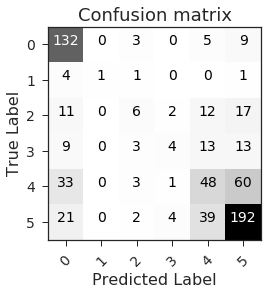

In [17]:
stats.print_big4(test_y_class, test_y_pred)
stats.print_stats(test_y_class, test_y_pred)
stats.plot_confusion_matrix(stats.cm(test_y_class, test_y_pred),classes=np.unique(test_y_class))

Accuracy: 81.972%
Precision: 82.745%
Recall: 81.972%
F1-Measure: 82.232%
Pearson's R: 0.60
Cohen's Kappa: 0.60
RMSE: 0.42
MAE: 0.18
Y-True Mean: 0.69
Y-Pred Mean: 0.65
Y-True Std Deviation: 0.46
Y-Pred Std Deviation: 0.48


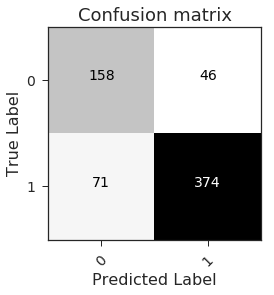

In [18]:
test_y_class_pf = utils.convert_to_pass_fail(test_y_class)
test_y_pred_pf = utils.convert_to_pass_fail(test_y_pred)

stats.print_big4(test_y_class_pf, test_y_pred_pf)
stats.print_stats(test_y_class_pf, test_y_pred_pf)
stats.plot_confusion_matrix(stats.cm(test_y_class_pf, test_y_pred_pf),classes=np.unique(test_y_class_pf))

In [204]:
examples = [
    ['Jane shot Bob', 'Bob shot Jane'],
    ['Jane shot Bob', 'Jane did not shoot Bob'],
    ['Its puts the lotion in the basket', 'this is a long sentence that is meaningless and has virtually no shared characteristics with the model answer'],
    ['A function has a name and a list of arguments', 'functions have many things, they are required to have a name and can optionally have parameters'],
    ['A function has a name and a list of arguments', 'I really have no idea']
]

res = create_features(nlp_en, gensim_model, examples)
res2 = res[:, :9]

y_pred_tmp = forest_clf.predict(res2)
print(y_pred_tmp)

[5 5 4 5 2]
